In [1]:
from ultralytics import YOLO
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import torch
import numpy as np
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt
import os
from  detects import segany_mask_generate,yolo_mask_generate,vote_mask_generate,plot_sam_mask, pipeline
#sam = sam_model_registry["vit_h"](checkpoint="./segany/sam_vit_h_4b8939.pth")
sam = sam_model_registry["vit_l"](checkpoint="./segany/sam_vit_l_0b3195.pth").to("cuda")
#sam = sam_model_registry["vit_b"](checkpoint="./segany/sam_vit_b_01ec64.pth").to("cuda")

sam_model_generator = SamAutomaticMaskGenerator(sam,
                                                crop_n_layers=2,
                                                crop_n_points_downscale_factor=2)
yolo_model = YOLO('./yolo/ver3.pt')


d:\Anaconda\envs\CVproj\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def vote_mask_generate(SAM_masks,YOLO_masks,threshold=0.8,erode_iter=1,erode_kernel_size=2):
    scores = []
    #把yolo_masks给resize到和SAM_masks一样的大小
    zeros = np.zeros_like(SAM_masks[0])
    #zeros与所有的SAM_masks进行或运算，得到一个和SAM_masks一样大小的mask 然后取反，得到所有的未标注区域，然后与YOLO_masks相与，得到所有的未标注区域的YOLO_masks
    full_mask = np.zeros_like(SAM_masks[0])
    for i, mask in enumerate(SAM_masks):
        full_mask = cv2.bitwise_or(full_mask,mask)
    #对YOLO_masks先进行一些腐蚀
    kernel = np.ones((erode_kernel_size,erode_kernel_size),np.uint8)
    YOLO_masks = cv2.erode(YOLO_masks,kernel,iterations = erode_iter)
    YOLO_masks = cv2.resize(YOLO_masks, (SAM_masks[0].shape[1], SAM_masks[0].shape[0])).astype(np.uint8)
    not_labeled = cv2.bitwise_not(cv2.bitwise_or(zeros, full_mask))
    final_mask = np.zeros_like(SAM_masks[0])
    for i, mask in enumerate(SAM_masks):
        score = np.sum(YOLO_masks*mask/mask.sum())
        scores.append(score)
        if score > threshold:
            #或运算
            final_mask = cv2.bitwise_or(final_mask,mask)
        #print(score)
    not_labeled_yolo = cv2.bitwise_and(not_labeled, YOLO_masks)
    final_mask = cv2.bitwise_or(final_mask,not_labeled_yolo)

    return final_mask

In [3]:
path = "D:/pyprojs/Anime-seg-yolov8/samples/sample.jpg"
image = Image.open(path).convert("RGB")
yolo_masks, _= yolo_mask_generate(yolo_model,image)
sam_masks = segany_mask_generate(sam_model_generator,image)
voted_mask = vote_mask_generate(sam_masks,yolo_masks,threshold=0.3)


0: 640x544 10 persons, 119.4ms
Speed: 5.1ms preprocess, 119.4ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)


In [3]:
def pipeline(seg_model, yolo_model, image_path, threshold=0.3):
    output_masks = []
    images = []
    output_images = []
    if os.path.isdir(image_path):
        for image_path in os.listdir(image_path):
            image = Image.open(image_path).convert("RGB")
            yolo_masks, _= yolo_mask_generate(yolo_model,image)
            sam_masks = segany_mask_generate(seg_model,image)
            voted_mask = vote_mask_generate(sam_masks,yolo_masks,threshold=threshold)
            output_masks.append(voted_mask)
            images.append(image)
    else:
        image = Image.open(image_path).convert("RGB")
        yolo_masks, _= yolo_mask_generate(yolo_model,image)
        sam_masks = segany_mask_generate(seg_model,image)
        voted_mask = vote_mask_generate(sam_masks,yolo_masks,threshold=threshold)
        output_masks.append(voted_mask)
        images.append(image)
    for i, mask in enumerate(output_masks):
        image = images[i]
        image = np.array(image.convert("RGBA"))
        mask = np.array(mask)
        #mask大于0的地方，image的alpha通道为255，否则为0
        image[:,:,3] = mask*255
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGRA)
        output_images.append(image)
    

    return output_masks, output_images

In [5]:
output_masks, output_images = pipeline(sam_model_generator, yolo_model, "D:/pyprojs/Anime-seg-yolov8/samples/sample.jpg", threshold=0.3)

0: 640x544 10 persons, 249.7ms
Speed: 3.0ms preprocess, 249.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


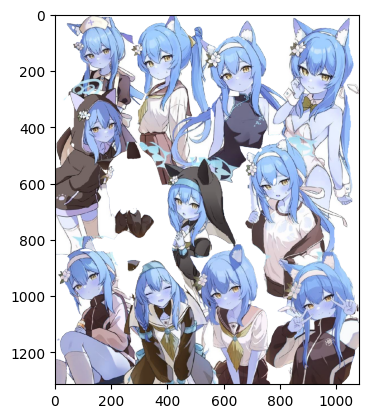

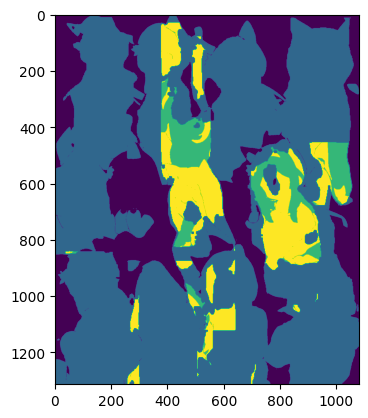

In [6]:
plt.imshow(output_images[0])
plt.show()
plt.imshow(output_masks[0])
plt.show()

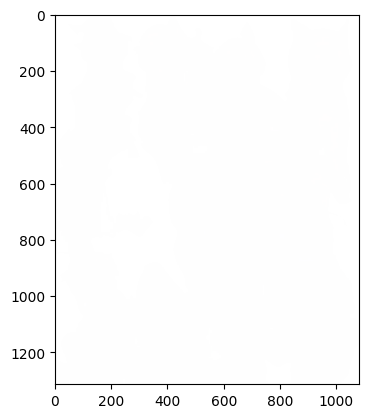

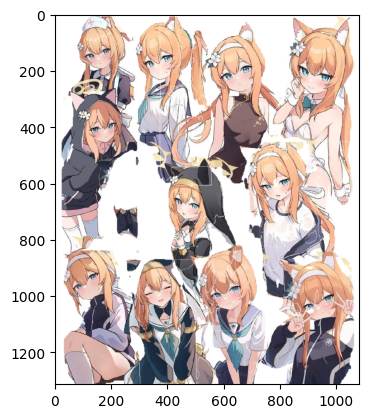

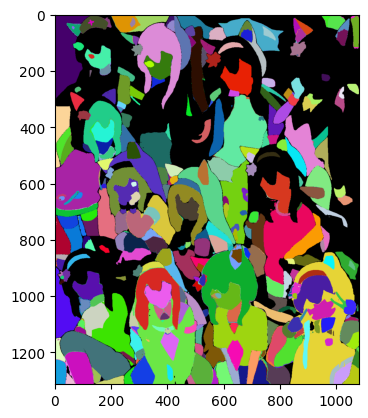

True

In [4]:
#根据mask生成最终的图片,保留透明通道
image_out = np.array(image.convert("RGBA"))
#RGBA转成BGRA
#如果是jpg图片，需要把它转换成png图片
#voted_mask取反
image_out[:,:,3] = (voted_mask)*255
#保存图片
plt.imshow(image_out)
plt.show()
image_out[:,:,3] = (cv2.resize(yolo_masks,voted_mask.shape[::-1])) * 255
plt.imshow(image_out)
plt.show()
plt.imshow(plot_sam_mask(sam_masks))
plt.show()
image_out = cv2.cvtColor(image_out, cv2.COLOR_RGBA2BGRA)
cv2.imwrite(f"./samples/"+'sam_mask'+path.split('/')[-1].split('.')[0]+'.png',image_out)
image_out[:,:,3] = (cv2.resize(voted_mask,voted_mask.shape[::-1])) * 255
cv2.imwrite(f"./samples/"+'yolo_mask'+path.split('/')[-1].split('.')[0]+'.png',image_out)

In [4]:
path = r"D:\pyprojs\Anime-seg-yolov8\samples"
pipeline( sam_model_generator, yolo_model, path)

Processing 451.jpg:   0%|          | 0/2 [00:00<?, ?it/s]


D:\pyprojs\Anime-seg-yolov8\samples


0: 640x640 2 persons, 22.4ms
Speed: 2.2ms preprocess, 22.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Processing 451.jpg:   0%|          | 0/2 [00:13<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "d:\Anaconda\envs\CVproj\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\64930\AppData\Local\Temp\ipykernel_64820\3190383635.py", line 2, in <module>
    pipeline( sam_model_generator, yolo_model, path)
  File "d:\pyprojs\Anime-seg-yolov8\detects.py", line 87, in pipeline
NameError: name 'bboxes' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\Anaconda\envs\CVproj\lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "d:\Anaconda\envs\CVproj\lib\site-packages\IPython\core\ultratb.py", line 1310, in structured_traceback
    return FormattedTB.structured_traceback(
  File "d:\Anaconda\envs\CVproj\lib\site-packages\IPython\core\ultratb.py", line 1199, in structured_traceback
    retur

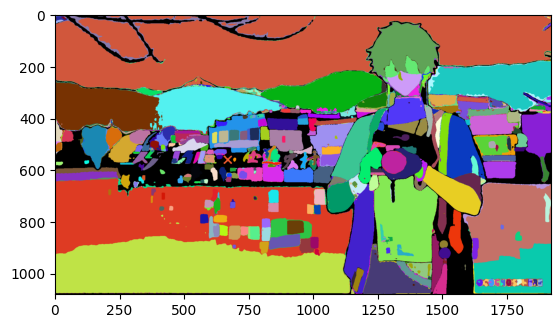

In [12]:
plt.imshow(plot_sam_mask(sam_masks))

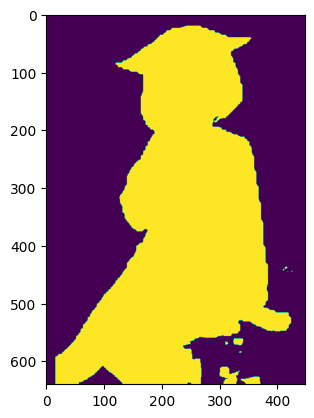

In [9]:
plt.imshow(yolo_masks)

In [9]:
image = Image.open("./samples/451.jpg").convert("RGB")
def yolo_mask_generate(yolo_model, image,expand_rate = 1.1):
    if isinstance(image, str):
        image = cv2.imread(image)
    if isinstance(image, Image.Image):
        image = np.array(image)
    # 生成mask
    masks = yolo_model(image)
    bboxes = masks[0].boxes.xyxyn.detach().cpu().numpy()
    masks = masks[0].masks.data.data.cpu().numpy().sum(axis=0)
    # 按照bboxes的大小，对mask进行裁剪
    bboxes = np.concatenate((bboxes.min(axis=0)[:2],bboxes.max(axis=0)[2:]))
    return masks[0].masks.data.data.cpu().numpy().sum(axis=0),bboxes
#yolo_mask_generate(yolo_model,image)
image = np.array(image)[:,:,::-1]
out = yolo_model(image)


0: 640x640 2 persons, 265.5ms
Speed: 5.0ms preprocess, 265.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


In [20]:
# 前两个取最小的 后两个取最大的
boxes = out[0].boxes.xyxyn.detach().cpu().numpy()
boxes_ = np.concatenate((boxes.min(axis=0)[:2],boxes.max(axis=0)[2:]))

In [5]:
image = Image.open("./samples/451.jpg").convert("RGB")
out = yolo_model(image)
boxes = out[0].boxes.xyxy.detach().cpu().numpy()


0: 640x640 2 persons, 255.5ms
Speed: 4.0ms preprocess, 255.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


In [6]:
boxes

array([[      27.44,      15.576,      320.12,      591.18],
       [     339.32,      13.705,      583.72,      590.74]], dtype=float32)